## Obligatorio de Deep Learning - Semestre 2 - 2022

## 1. Setup

### 1.1 Imports

In [72]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import os
if os.path.exists("/content/drive/MyDrive/ORT/DeepLearning/Obligatorio"):
  os.chdir('/content/drive/MyDrive/ORT/DeepLearning/Obligatorio')
else:
  os.chdir("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio")


In [74]:
!ls

 data
'Deep Learning - Obligatorio 2022.pdf'
 kaggle_test_output.csv
 kaggle_test_outputmodel_maxLen19_batchSize32_epochs120221114_030824.csv
 kaggle_test_outputmodel_maxLen19_batchSize32_epochs1920221114_042718.csv
 kaggle_test_outputModelWithBN_maxLen19_batchSize32_epochs1920221114_054238.csv
 kaggle_test_outputModelWithGCandBN_maxLen19_batchSize32_epochs1920221114_081729.csv
 kaggle_test_outputModelWithGC_maxLen19_batchSize32_epochs1920221114_065842.csv
 outputs
 __pycache__
 Referencias.gdoc
'Template HDFS Log Classification.ipynb'
 utils.py


In [156]:
import numpy as np
import datetime as dt
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


from importlib import reload
import utils
utils = reload(utils)

### 1.2 Set random seeds

In [76]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [77]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [78]:
hdfs_train[:4]

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal


In [79]:
hdfs_test_kaggle[:5]

,id,sequence
0,0,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)"
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,..."
2,2,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."
3,3,"(4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,..."
4,4,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,..."


## 3. Análisis exploratorio de datos

### 3.1 Análisis descriptivo general: Distribuciones, Scatterplots, Barplots...

In [80]:
hdfs_train.head()

,id,sequence,class
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal


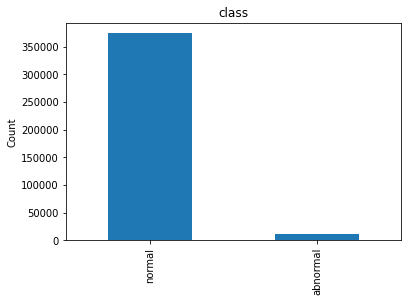

In [81]:
utils.value_counts(hdfs_train,'class')

### 3.2 Análisis de secuencias

In [82]:
#Agregar ploteo de largos de secuencias, distribuciones por simbolo, etc.

In [83]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)
#raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
try:
    data_y.value_counts()
except:
    pass

In [85]:
min([min(s) for s in raw_sequences])

1

In [86]:
max([max(s) for s in raw_sequences])

28

In [87]:
np.median([len(s) for s in raw_sequences])

19.0

###Hiperarámetros

In [88]:
vocab_size = 30#max([max(s) for s in raw_sequences]) + 1
max_len = 19
batch_size = 32
epochs = 20
patience = 10
optimizer = Adam() #para agregar clip value clipvalue=0.5
loss = 'categorical_crossentropy'
embedding_size = 3#math.ceil(vocab_size**0.25) #es un hiperparametro. cuanto mas grande, mayor el entrenamiento

#### Haremos padding de valor 0 a las secuencias para estandarizar el largo

In [89]:
padded_sequences = utils.pad_sequences(raw_sequences, max_len)

# Data preprocessing


## Particionamiento

In [90]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)


## X_train_aug Data Augmentation

In [150]:
X_train_for_aug, a, b, c, d, e = utils.split(raw_sequences, data_y)


In [151]:
X_train_aug, y_train_aug = utils.sequences_augmentation(X_train_for_aug, y_train, max_len, 19)

In [152]:
"""
padding to data augmentation traing
"""
X_train_aug = utils.pad_sequences(X_train_aug, max_len)


# 4. Entrenamiento de Language Model



### Grid Search

### Model Mejorado 

#### Entrenamiento

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 3)             93        
                                                                 
 lstm (LSTM)                 (None, 19, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#se agregó class.weights
training, model = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/19
8128/8128 [==============================] - 226s 27ms/step - loss: 0.0575 - accuracy: 0.9914 - val_loss: 0.0083 - val_accuracy: 0.9989
Epoch 2/19
8128/8128 [==============================] - 222s 27ms/step - loss: 0.0169 - accuracy: 0.9979 - val_loss: 0.0122 - val_accuracy: 0.9988
Epoch 3/19
8128/8128 [==============================] - 223s 27ms/step - loss: 0.0130 - accuracy: 0.9983 - val_loss: 0.0057 - val_accuracy: 0.9985
Epoch 4/19
8128/8128 [==============================] - 222s 27ms/step - loss: 0.0101 - accuracy: 0.9987 - val_loss: 0.0067 - val_accuracy: 0.9989
Epoch 5/19
8128/8128 [==============================] - 226s 28ms/step - loss: 0.0109 - accuracy: 0.9987 - val_loss: 0.0054 - val_accuracy: 0.9993
Epoch 6/19
8128/8128 [==============================] - 227s 28ms/step - loss: 0.0093 - accuracy: 0.9989 - val_loss: 0.0063 - val_accuracy: 0.9993
Epoch 7/19
8128/8128 [==============================] - 226s 28ms/step - loss: 0.0090 - accuracy: 0.9989 - val_loss: 0

#### Evaluation

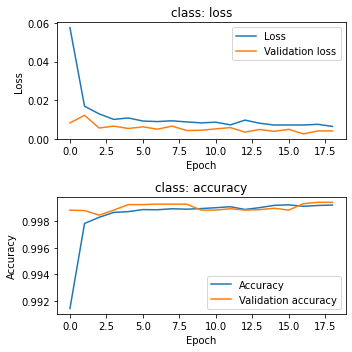

3011/3011 [==============================] - 29s 9ms/step


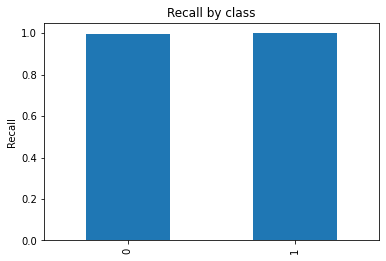

Classification report
              precision    recall  f1-score   support

    abnormal       0.99      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      1.00     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.0040457285940647125, accuracy: 0.9994393587112427


In [ ]:
utils.eval_model(training, model, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='model'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(model, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = model.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 54s 9ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization

In [ ]:
modelBN = Sequential()
modelBN.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelBN.add(LSTM(64, return_sequences=True))
modelBN.add(LSTM(64, return_sequences=False))
modelBN.add(BatchNormalization())
modelBN.add(Dense(2, activation='softmax'))
modelBN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
modelBN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_2 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,911
Trainable params: 50,783
Non-trainable params: 128
________________________________________________

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingBN, modelBN = utils.train(modelBN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/19
8128/8128 [==============================] - 236s 28ms/step - loss: 0.0286 - accuracy: 0.9952 - val_loss: 0.0100 - val_accuracy: 0.9988
Epoch 2/19
8128/8128 [==============================] - 231s 28ms/step - loss: 0.0159 - accuracy: 0.9980 - val_loss: 0.0218 - val_accuracy: 0.9988
Epoch 3/19
8128/8128 [==============================] - 230s 28ms/step - loss: 0.0142 - accuracy: 0.9982 - val_loss: 0.0064 - val_accuracy: 0.9989
Epoch 4/19
8128/8128 [==============================] - 230s 28ms/step - loss: 0.0128 - accuracy: 0.9985 - val_loss: 0.0115 - val_accuracy: 0.9989
Epoch 5/19
8128/8128 [==============================] - 232s 29ms/step - loss: 0.0117 - accuracy: 0.9987 - val_loss: 0.0058 - val_accuracy: 0.9992
Epoch 6/19
8128/8128 [==============================] - 232s 29ms/step - loss: 0.0106 - accuracy: 0.9986 - val_loss: 0.0205 - val_accuracy: 0.9993
Epoch 7/19
8128/8128 [==============================] - 232s 29ms/step - loss: 0.0100 - accuracy: 0.9988 - val_loss: 0

#### Evaluation

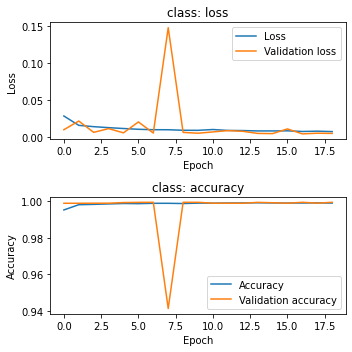

3011/3011 [==============================] - 28s 9ms/step


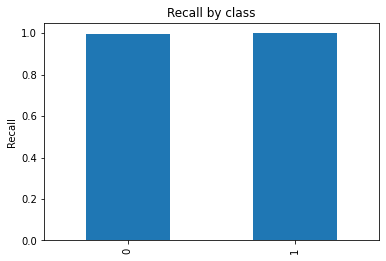

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.005258316174149513, accuracy: 0.9992005825042725


In [ ]:
utils.eval_model(trainingBN, modelBN, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithBN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelBN, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelBN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelBN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 54s 9ms/step
Saved model to disk


### Modelo Mejorado con Gradient Clipping

In [ ]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [ ]:
modelGC = Sequential()
modelGC.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelGC.add(LSTM(64, return_sequences=True))
modelGC.add(LSTM(64, return_sequences=False))
modelGC.add(Dense(2, activation='softmax'))
modelGC.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
modelGC.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_4 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC, modelGC = utils.train(modelGC,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/19
8128/8128 [==============================] - 234s 28ms/step - loss: 0.1238 - accuracy: 0.9850 - val_loss: 0.0102 - val_accuracy: 0.9985
Epoch 2/19
8128/8128 [==============================] - 227s 28ms/step - loss: 0.0169 - accuracy: 0.9985 - val_loss: 0.0115 - val_accuracy: 0.9993
Epoch 3/19
8128/8128 [==============================] - 229s 28ms/step - loss: 0.0122 - accuracy: 0.9988 - val_loss: 0.0032 - val_accuracy: 0.9993
Epoch 4/19
8128/8128 [==============================] - 231s 28ms/step - loss: 0.0132 - accuracy: 0.9989 - val_loss: 0.0048 - val_accuracy: 0.9988
Epoch 5/19
8128/8128 [==============================] - 231s 28ms/step - loss: 0.0121 - accuracy: 0.9990 - val_loss: 0.0027 - val_accuracy: 0.9996
Epoch 6/19
8128/8128 [==============================] - 233s 29ms/step - loss: 0.0129 - accuracy: 0.9991 - val_loss: 0.0057 - val_accuracy: 0.9992
Epoch 7/19
8128/8128 [==============================] - 230s 28ms/step - loss: 0.0101 - accuracy: 0.9991 - val_loss: 0

#### Evaluation

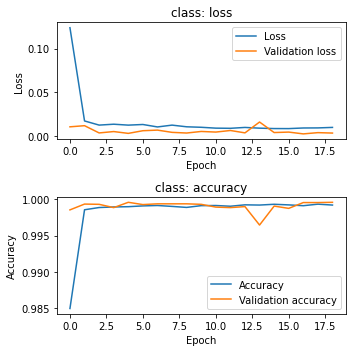

3011/3011 [==============================] - 29s 9ms/step


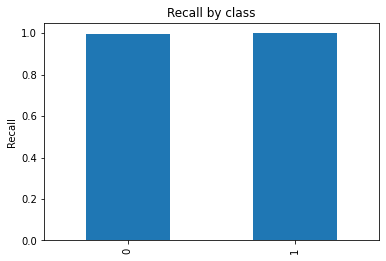

Classification report
              precision    recall  f1-score   support

    abnormal       0.99      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      1.00     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.003105881391093135, accuracy: 0.9995017051696777


In [ ]:
utils.eval_model(trainingGC, modelGC, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGC'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGC, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGC.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGC.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


5931/5931 [==============================] - 54s 9ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization y Gradient Clipping

In [ ]:
modelGC_BN = Sequential()
modelGC_BN.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelGC_BN.add(LSTM(64, return_sequences=True))
modelGC_BN.add(LSTM(64, return_sequences=False))
modelGC_BN.add(BatchNormalization())
modelGC_BN.add(Dense(2, activation='softmax'))
modelGC_BN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
modelGC_BN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_6 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,911
Trainable params: 50,783
Non-trainable params: 128
________________________________________________

#### Entrenamiento

In [ ]:
#se agregó class.weights
trainingGC_BN, modelGC_BN = utils.train(modelGC_BN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/19
8128/8128 [==============================] - 239s 29ms/step - loss: 0.0309 - accuracy: 0.9976 - val_loss: 0.0097 - val_accuracy: 0.9993
Epoch 2/19
8128/8128 [==============================] - 231s 28ms/step - loss: 0.0257 - accuracy: 0.9991 - val_loss: 0.0814 - val_accuracy: 0.9901
Epoch 3/19
8128/8128 [==============================] - 260s 32ms/step - loss: 0.0259 - accuracy: 0.9992 - val_loss: 0.0569 - val_accuracy: 0.9926
Epoch 4/19
8128/8128 [==============================] - 232s 29ms/step - loss: 0.0282 - accuracy: 0.9992 - val_loss: 0.5086 - val_accuracy: 0.8382
Epoch 5/19
8128/8128 [==============================] - 233s 29ms/step - loss: 0.0240 - accuracy: 0.9991 - val_loss: 0.0037 - val_accuracy: 0.9996
Epoch 6/19
8128/8128 [==============================] - 234s 29ms/step - loss: 0.0198 - accuracy: 0.9992 - val_loss: 0.0353 - val_accuracy: 0.9989
Epoch 7/19
8128/8128 [==============================] - 234s 29ms/step - loss: 0.0211 - accuracy: 0.9992 - val_loss: 0

#### Evaluation

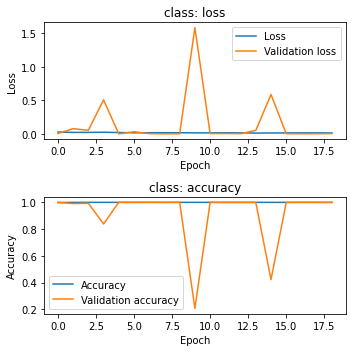

3011/3011 [==============================] - 28s 9ms/step


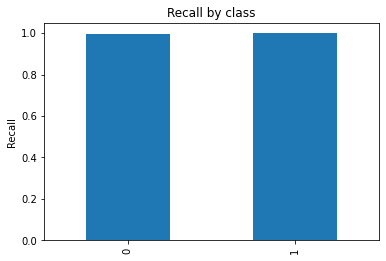

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.009101071394979954, accuracy: 0.9984738826751709


In [ ]:
utils.eval_model(trainingGC_BN, modelGC_BN, X_test, y_test)

####Generación modelo y Salida Kaggle

In [ ]:
name='ModelWithGCandBN'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGC_BN, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGC_BN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGC_BN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 54s 9ms/step
Saved model to disk


### Modelo Mejorado con Data Augmentation

In [93]:
modelDA = Sequential()
modelDA.add(Embedding(vocab_size+1, embedding_size, input_length=max_len)) #el vocab size deberiamos sacarlo
modelDA.add(LSTM(64, return_sequences=True))
modelDA.add(LSTM(64, return_sequences=False))
modelDA.add(Dense(2, activation='softmax'))
modelDA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
modelDA.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_12 (LSTM)              (None, 19, 64)            17408     
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,655
Trainable params: 50,655
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [153]:
#se agregó class.weights
trainingDA, modelDA = utils.train(modelDA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/19
10472/10472 [==============================] - 296s 28ms/step - loss: 0.0548 - accuracy: 0.9861 - val_loss: 0.0087 - val_accuracy: 0.9985
Epoch 2/19
10472/10472 [==============================] - 294s 28ms/step - loss: 0.0208 - accuracy: 0.9970 - val_loss: 0.0065 - val_accuracy: 0.9989
Epoch 3/19
10472/10472 [==============================] - 293s 28ms/step - loss: 0.0171 - accuracy: 0.9977 - val_loss: 0.0084 - val_accuracy: 0.9990
Epoch 4/19
10472/10472 [==============================] - 288s 27ms/step - loss: 0.0135 - accuracy: 0.9980 - val_loss: 0.0042 - val_accuracy: 0.9988
Epoch 5/19
10472/10472 [==============================] - 305s 29ms/step - loss: 0.0134 - accuracy: 0.9985 - val_loss: 0.0215 - val_accuracy: 0.9956
Epoch 6/19
10472/10472 [==============================] - 308s 29ms/step - loss: 0.0120 - accuracy: 0.9984 - val_loss: 0.0053 - val_accuracy: 0.9993
Epoch 7/19
10472/10472 [==============================] - 289s 28ms/step - loss: 0.0125 - accuracy: 0.9986

#### Evaluation

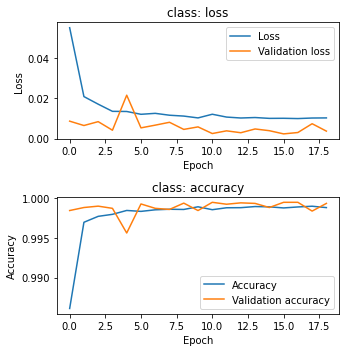

3011/3011 [==============================] - 28s 9ms/step


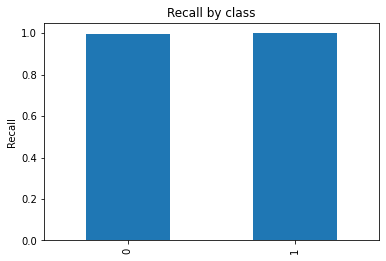

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004298139829188585, accuracy: 0.9992836713790894


In [154]:
utils.eval_model(trainingDA, modelDA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [155]:
name='ModelWithDataAugmentation'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelDA, hdfs_test_kaggle, max_len, name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelDA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelDA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(max_len)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 52s 9ms/step
Saved model to disk


## 6 Consigna

### A) Participación en Competencia Kaggle:
El objetivo de este punto es participar en la competencia de Kaggle y obtener como mínimo un Macro Average Recall (o Weighted Accuracy) superior al 80%. [->Link a la competencia<-](https://www.kaggle.com/t/6d15e3a96bd049b2b4b2a491a69a0fc7).

### B) Utilización de Grid Search (o equivalente):
Para cumplir con la busqueda de modelos óptimos se debe realizar un grid search lo más abarcativo y metódico posible.

### C) Se debe a su vez investigar e implementar al menos 2 de las siguientes técnicas:
#### 1. [Batch Normalization](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
#### 2. [Data Augmentation a través de la realización de Windowing](https://blog.finxter.com/how-to-loop-through-a-python-list-in-batches/#Method_1_Iterating_over_Consecutive_Sliding_Windows)
#### 3. [Gradient Normalization y/o Gradient Clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)
